In [2]:
import geopandas as gpd
import pandas as pd


                NAME  STATE_NAME STATE_FIPS CNTY_FIPS   FIPS  \
0  Lake of the Woods   Minnesota         27       077  27077   
1              Ferry  Washington         53       019  53019   
2            Stevens  Washington         53       065  53065   
3           Okanogan  Washington         53       047  53047   
4       Pend Oreille  Washington         53       051  53051   

                                            geometry  
0  POLYGON ((-95.34283 48.54668, -95.34105 48.715...  
1  POLYGON ((-118.85163 47.94956, -118.84846 48.4...  
2  POLYGON ((-117.43883 48.04412, -117.54219 48.0...  
3  POLYGON ((-118.97209 47.93915, -118.97406 47.9...  
4  POLYGON ((-117.43858 48.99992, -117.03205 48.9...  


<Axes: >

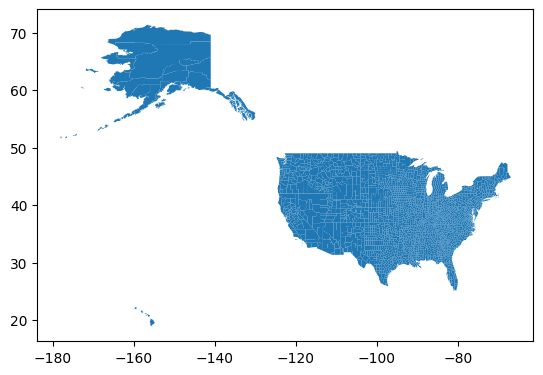

In [3]:
shapefile_path = "UScounties.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.head())
gdf.plot()

In [4]:
covid_data = pd.read_csv("covidData2021-2022.csv")
print(covid_data.head())

         date     county       state     fips  cases  deaths
0  2020-01-21  Snohomish  Washington  53061.0      1     0.0
1  2020-01-22  Snohomish  Washington  53061.0      1     0.0
2  2020-01-23  Snohomish  Washington  53061.0      1     0.0
3  2020-01-24       Cook    Illinois  17031.0      1     0.0
4  2020-01-24  Snohomish  Washington  53061.0      1     0.0


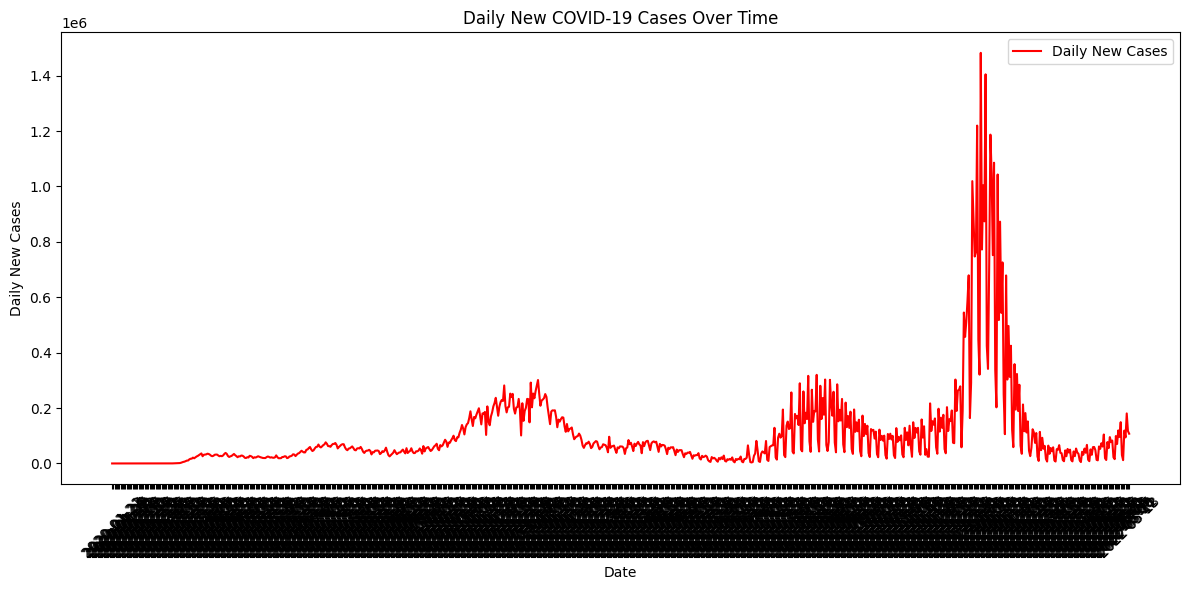

In [13]:
import matplotlib.pyplot as plt

# Assuming the data is already loaded and named as `df`
covid_data['daily_new_cases'] = covid_data.groupby(['county', 'state'])['cases'].diff().fillna(covid_data['cases'])
covid_data['daily_new_cases'] = covid_data['daily_new_cases'].apply(lambda x: x if x >= 0 else 0)

# Summing up daily new cases across all counties and states for each day
daily_new_cases = covid_data.groupby('date')['daily_new_cases'].sum().reset_index()

# Plotting the daily new COVID-19 cases
plt.figure(figsize=(12, 6))
plt.plot(daily_new_cases['date'], daily_new_cases['daily_new_cases'], label='Daily New Cases', color='red')
plt.title('Daily New COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
import numpy as np

# Convert 'date' to datetime object
covid_data['date'] = pd.to_datetime(covid_data['date'])

# Find the end of week date (Friday) for each entry
covid_data['end_of_week'] = covid_data['date'] + pd.to_timedelta(
    (4 - covid_data['date'].dt.weekday) % 7, unit='d')

# Now group by 'end_of_week' and 'fips' and sum the 'daily_new_cases'
weekly_cases = covid_data.groupby(['fips', 'end_of_week'])['daily_new_cases'].sum().reset_index()

# This DataFrame 'weekly_cases' now has weekly summed cases for each FIPS code.
weekly_cases.head(20)

,fips,end_of_week,daily_new_cases
0,1001.0,2020-03-27,6.0
1,1001.0,2020-04-03,6.0
2,1001.0,2020-04-10,5.0
3,1001.0,2020-04-17,9.0
4,1001.0,2020-04-24,11.0
5,1001.0,2020-05-01,7.0
6,1001.0,2020-05-08,25.0
7,1001.0,2020-05-15,37.0
8,1001.0,2020-05-22,46.0
9,1001.0,2020-05-29,63.0


In [20]:
# Assuming 'weekly_cases' DataFrame has 'fips' and 'end_of_week' columns from earlier steps

# Create a sorted list of unique FIPS codes
unique_fips = weekly_cases['fips'].unique()

# Create a sorted list of unique weeks (end_of_week dates)
unique_weeks = weekly_cases['end_of_week'].unique()

# Generate all combinations of FIPS codes and weeks
import itertools

fips_week_combinations = list(itertools.product(unique_fips, unique_weeks))

# Convert to DataFrame
fips_weeks = pd.DataFrame(fips_week_combinations, columns=['FIPS', 'Week'])

# Now we have a DataFrame 'fips_weeks' ready for use as nodes in the Bayesian network
fips_weeks.head(-20)

,FIPS,Week
0,1001.0,2020-03-27
1,1001.0,2020-04-03
2,1001.0,2020-04-10
3,1001.0,2020-04-17
4,1001.0,2020-04-24
...,...,...
389595,78030.0,2022-01-28
389596,78030.0,2022-02-04
389597,78030.0,2022-02-11
389598,78030.0,2022-02-18


In [22]:
# Merge the `weekly_cases` data with `fips_weeks` to associate the number of new cases with each FIPS code and week.
complete_data = pd.merge(fips_weeks, weekly_cases, how='left', left_on=['FIPS', 'Week'], right_on=['fips', 'end_of_week'])

# Fill any NaN values that result from weeks where a FIPS code had no reported cases with zeros.
complete_data['daily_new_cases'].fillna(0, inplace=True)

# You now have a complete dataset to use as input for your Bayesian network.
# Each row represents a node, with columns for the FIPS code, the week, and the number of new cases.

complete_data.head(-20)

,FIPS,Week,fips,end_of_week,daily_new_cases
0,1001.0,2020-03-27,1001.0,2020-03-27,6.0
1,1001.0,2020-04-03,1001.0,2020-04-03,6.0
2,1001.0,2020-04-10,1001.0,2020-04-10,5.0
3,1001.0,2020-04-17,1001.0,2020-04-17,9.0
4,1001.0,2020-04-24,1001.0,2020-04-24,11.0
...,...,...,...,...,...
389595,78030.0,2022-01-28,78030.0,2022-01-28,262.0
389596,78030.0,2022-02-04,78030.0,2022-02-04,56.0
389597,78030.0,2022-02-11,78030.0,2022-02-11,73.0
389598,78030.0,2022-02-18,78030.0,2022-02-18,18.0


In [23]:
import geopandas as gpd

# Load the shapefile
gdf_counties = gpd.read_file(shapefile_path)


In [26]:
def get_neighbors(fips_code):
    # Select the county based on FIPS code
    county = counties[counties['FIPS'] == str(fips_code)]
    if county.empty:
        return []

    # Use spatial joins to find neighbors
    neighbors = gpd.sjoin(counties, county, op='touches')
    neighbor_fips = neighbors['FIPS_left'].tolist()
    return [f for f in neighbor_fips if f != str(fips_code)]


In [27]:
from pgmpy.models import BayesianNetwork

# Initialize an empty Bayesian Network
bayesian_network = BayesianNetwork()

# Add nodes. Assuming 'complete_data' is already loaded with the necessary columns.
nodes = [(row['FIPS'], row['Week']) for index, row in complete_data.iterrows()]
bayesian_network.add_nodes_from(nodes)


In [28]:
# Generate all potential edges from consecutive weeks but only between neighbors
potential_edges = []
for week in unique_weeks[:-1]:
    current_week_fips = complete_data[complete_data['Week'] == week]['FIPS'].unique()
    next_week_fips = complete_data[complete_data['Week'] == week]['FIPS'].unique()
    
    for fips in current_week_fips:
        neighbors = get_neighbors(fips)
        for neighbor in neighbors:
            if neighbor in next_week_fips:
                potential_edges.append(((fips, week), (neighbor, week)))

# Restrict Bayesian network's possible edges to these potential edges
bayesian_network.add_edges_from(potential_edges)


NameError: name 'counties' is not defined